In [1]:
from visual_behavior.visualization.qc import data_loading as dl
import visual_behavior.validation.sdk as sdk_validation
import visual_behavior.database as db
from allensdk.brain_observatory.behavior.behavior_project_cache import BehaviorProjectCache as bpc
from allensdk.brain_observatory.behavior.behavior_ophys_session import BehaviorOphysSession
import visual_behavior.utilities as vbu
import visual_behavior.plotting as vbp

from multiprocessing import Pool
import time

%widescreen
%standard_imports
%matplotlib notebook

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


imported:
	os
	pandas as pd
	numpy as np
	matplotlib.pyplot as plt


In [2]:
def designate_flashes(ax, omit=None, pre_color='blue', post_color='blue'):
    '''add vertical spans to designate stimulus flashes'''
    lims = ax.get_xlim()
    for flash_start in np.arange(0, lims[1], 0.75):
        if flash_start != omit:
            ax.axvspan(flash_start, flash_start+0.25,
                       color=post_color, alpha=0.25, zorder=-np.inf)
    for flash_start in np.arange(-0.75, lims[0]-0.001, -0.75):
        if flash_start != omit:
            ax.axvspan(flash_start, flash_start+0.25,
                       color=pre_color, alpha=0.25, zorder=-np.inf)

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
MANIFEST_PATH = "//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/2020_cache/production_cache/manifest.json"
cache = bpc.from_lims(manifest=MANIFEST_PATH)

In [5]:
filtered_session_table = dl.get_filtered_ophys_sessions_table().drop_duplicates('ophys_session_id')

In [6]:
# pull in pass/fail data from the sdk validation log
data_availability = []
for behavior_session_id in filtered_session_table['behavior_session_id'].unique():
    data_availability.append(sdk_validation.get_validation_results(int(behavior_session_id))[['eye_tracking','running_data_df','stimulus_presentations','rewards']])
data_availability = pd.concat(data_availability).reset_index()

In [7]:
# merge in data availability
filtered_session_table = filtered_session_table.merge(
    data_availability,
    left_on = 'behavior_session_id',
    right_on = 'behavior_session_id',
    how='left'
)

In [8]:
# get another table that includes only sessions with all necessary data streams
sessions_with_data = filtered_session_table.query('eye_tracking == 1 and stimulus_presentations == 1 and rewards == 1')

In [9]:
sessions_with_data.sample(10)

,ophys_session_id,behavior_session_id,ophys_experiment_id,project_code,session_name,session_type,equipment_name,date_of_acquisition,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,in_experiment_table,in_bsession_table,good_project_code,good_session,good_exp_workflow,good_container_workflow,container_id,container_workflow_state,eye_tracking,running_data_df,stimulus_presentations,rewards
403,974486549,974634733,"[974994093, 974994095, 974994097, 974994099, 9...",VisualBehaviorMultiscope,20191031_484627_Ophys6,OPHYS_6_images_B,MESO.1,2019-10-31 08:26:06.328780,930825455,M,115.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,False,1018027834,holding,1,0,1,1
230,1008813715,1008881178,[1009114207],VisualBehavior,20200221_495789_6ImagesB,OPHYS_6_images_B,CAM2P.3,2020-02-20 16:42:54.000000,975406504,M,162.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],True,True,True,True,True,False,1006071814,holding,1,1,1,1
356,1001860744,1002219417,[1002314807],VisualBehaviorTask1B,20200123_489056_3imagesB,OPHYS_3_images_B,CAM2P.3,2020-01-23 20:00:00.000000,951667115,M,172.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],True,True,True,True,True,False,999191979,holding,1,1,1,1
116,906968227,907053876,"[907694948, 907694950, 907694952, 907694954, 9...",VisualBehaviorMultiscope,20190716_453911_4imagesB,OPHYS_4_images_B,MESO.1,2019-07-16 08:09:56.532288,840390377,M,158.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,False,1018027878,holding,1,0,1,1
487,848894137,849147676,[849203565],VisualBehavior,20190410_445002_2imagesA,OPHYS_2_images_A_passive,CAM2P.3,2019-04-10 16:46:31.000000,820878213,M,98.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,True,846215539,container_qc,1,1,1,1
122,914639324,914705301,"[915243088, 915243090, 915243092, 915243094, 9...",VisualBehaviorMultiscope,20190731_453911_3imagesA_retake_2,OPHYS_3_images_A,MESO.1,2019-07-31 08:56:17.109568,840390377,M,173.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,False,1018027890,holding,1,0,1,1
341,1000439105,1000462035,"[1000744363, 1000744365, 1000744367, 100074437...",VisualBehaviorMultiscope,20200115_485152_ophys5,OPHYS_5_images_B_passive,MESO.1,2020-01-15 14:16:09.067721,935565389,M,188.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,False,1018027778,holding,1,0,1,1
394,833812106,833946929,[834279496],VisualBehavior,20190307_431252_4imagesB,OPHYS_4_images_B,CAM2P.4,2019-03-07 18:26:28.000000,784057626,F,140.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,True,829561794,container_qc,1,1,1,1
421,922743776,922869624,[923100548],VisualBehaviorTask1B,20190813_462544_6imagesA_retake,OPHYS_6_images_A,CAM2P.3,2019-08-13 20:01:40.000000,866070199,M,144.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,True,906963896,container_qc,1,1,1,1
100,928142719,928361913,[929132798],VisualBehaviorTask1B,20190821_464207_6imagesB,OPHYS_6_images_A,CAM2P.3,2019-08-21 15:24:27.000000,866228971,F,145.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",True,True,True,True,True,True,915584942,container_qc,1,1,1,1


In [10]:
sessions_with_data['equipment_name'].value_counts()

MESO.1     130
CAM2P.3    116
CAM2P.4     69
CAM2P.5     64
Name: equipment_name, dtype: int64

In [11]:
# a method to load the session object. By loading the necessary attributes here, they'll be cached in memory for later
def get_session(ophys_session_id):
    osid = ophys_session_id
    oeid = cache.get_session_table().loc[osid]['ophys_experiment_id'][0]
    session = BehaviorOphysSession.from_lims(oeid)
    eye_data = session.eye_tracking
    eye_data['blink_filtered_pupil_area'] = np.nan
    eye_data.loc[~eye_data['likely_blink'],'blink_filtered_pupil_area'] = eye_data['pupil_area']
    eye_data['normalized_pupil_area'] = eye_data['blink_filtered_pupil_area'] / np.percentile(eye_data['blink_filtered_pupil_area'].dropna(), 99)
    running_data = session.running_data_df
    stimuli = session.stimulus_presentations
    rewards = session.rewards

    return {ophys_session_id: session}

In [12]:
%%time
# Load all of the session objects. This parallelizes the process
osids = sessions_with_data['ophys_session_id'].unique()
with Pool(32) as pool:
    list_of_sessions = pool.map(get_session, osids)

# turn the list of dictaries into a single dictionary
session_dict = {k:v for k,v in [list(entry.items())[0] for entry in list_of_sessions]}

CPU times: user 9.25 s, sys: 20.6 s, total: 29.9 s
Wall time: 8min 27s


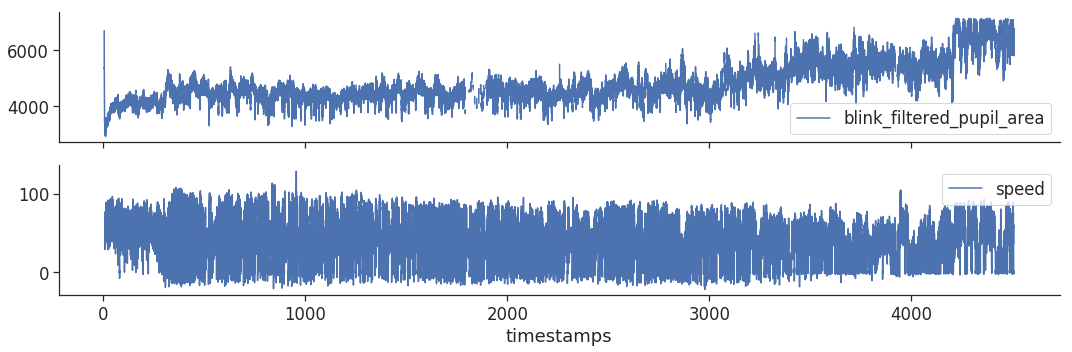

In [13]:
# plot one example session
session = session_dict[910345059]
fig,ax=plt.subplots(2,1,figsize=(15,5),sharex=True)
session.eye_tracking.plot(x='time',y='blink_filtered_pupil_area',ax=ax[0])
session.running_data_df.plot(y='speed',ax=ax[1])
fig.tight_layout()


## an attempt at clustering to filter out bad sessions

In [14]:
# compute a bunch of features

eye_tracking_summary = []
for osid in session_dict.keys():
    d = dict(session_dict[osid].eye_tracking['blink_filtered_pupil_area'].describe())
    d.update({
        'osid':osid,
        'nan_count':pd.isnull(session_dict[osid].eye_tracking['blink_filtered_pupil_area']).sum(),
        '99_percentile':np.percentile(session_dict[osid].eye_tracking['blink_filtered_pupil_area'].dropna(),99),
    })
    d.update({'diff_{}'.format(k):v for k,v in dict(session_dict[osid].eye_tracking['blink_filtered_pupil_area'].diff().describe()).items()})
    eye_tracking_summary.append(d)
eye_tracking_summary = pd.DataFrame(eye_tracking_summary).set_index('osid')
eye_tracking_summary

,count,mean,std,min,25%,50%,75%,max,nan_count,99_percentile,diff_count,diff_mean,diff_std,diff_min,diff_25%,diff_50%,diff_75%,diff_max
osid,,,,,,,,,,,,,,,,,,
952430817,135195.0,6985.090212,3243.253189,2530.828198,4459.070055,5924.699577,8665.655178,21426.772311,3068,15575.383130,135136.0,0.005614,131.308439,-2013.759705,-63.794102,-1.019348,63.273555,2267.972314
954954402,134436.0,5357.168884,2210.701191,1227.362997,3757.167170,4846.666634,6457.419827,15291.885367,2296,13022.474960,134345.0,-0.022610,142.521773,-10743.998438,-63.636481,-2.084759,60.916442,10852.671067
955775716,134095.0,5687.927834,2376.512120,1727.098027,3979.045698,5167.676769,6791.249102,16000.605752,5648,13832.458200,134000.0,-0.044928,125.340588,-2241.530911,-64.876310,-3.041607,61.090543,2449.916017
957020350,132390.0,5631.943882,2321.172978,925.164559,3802.318043,5356.020202,7169.127472,16949.677118,4115,12035.401275,132314.0,-0.273227,127.182427,-1662.313695,-63.822279,-2.442550,60.881356,2043.948199
958105827,131457.0,5352.819709,1961.995577,1468.299372,3828.430497,5088.495891,6627.357355,12928.343261,4433,11225.458947,131338.0,-0.148151,114.822316,-1406.409001,-61.231449,-2.331886,58.403568,1691.631884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900802327,124140.0,4534.360462,1512.712448,2165.933713,3338.889242,4198.196268,5128.830877,10420.438513,11793,9226.505137,123363.0,-0.288611,105.244943,-1526.167120,-64.327901,-0.325868,63.841660,1190.351354
901759468,129380.0,4133.422199,1038.944137,1355.125362,3489.031163,4193.217391,4678.000673,10469.482323,6559,6976.605580,129121.0,-0.070419,95.279114,-1287.374900,-57.338816,-0.365640,57.010948,1563.128109
902777219,131976.0,4407.901604,828.091704,2364.324779,3869.000145,4140.179521,4805.180816,8334.815128,3928,6825.676364,131817.0,-0.020983,92.958762,-1020.765603,-57.867150,-0.351655,57.495489,1740.162992


In [15]:
# cluster on the features
from sklearn.cluster import KMeans, AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4).fit(eye_tracking_summary)
eye_tracking_summary['label'] = clustering.labels_
eye_tracking_summary.sort_values(by='99_percentile').tail(150)

,count,mean,std,min,25%,50%,75%,max,nan_count,99_percentile,diff_count,diff_mean,diff_std,diff_min,diff_25%,diff_50%,diff_75%,diff_max,label
osid,,,,,,,,,,,,,,,,,,,
927787876,130115.0,6469.868331,2074.931339,3405.673377,5170.749085,5777.210331,6932.773072,1.410242e+04,3712,13257.626235,129903.0,-0.081105,124.599489,-1.684434e+03,-69.037648,-1.338880,67.974887,2.151313e+03,0
935554523,124895.0,7484.413333,1797.714081,3376.082969,6260.687604,7118.791930,8600.396050,2.356409e+04,11139,13261.364262,124236.0,-0.352381,383.898992,-1.339031e+04,-121.899513,0.700316,123.008740,1.433856e+04,0
967965969,128721.0,7902.760502,2374.758501,3200.167728,5713.078176,7570.023983,10023.969270,1.620333e+04,7191,13288.018614,128246.0,0.045430,252.282276,-6.164992e+03,-129.615087,1.049002,131.398050,6.689449e+03,0
878436988,258760.0,8660.553923,1772.152078,3788.563608,7331.633248,8361.811831,9871.249177,1.483267e+04,13414,13300.194795,257835.0,-0.063700,191.036842,-5.601042e+03,-103.630180,-0.284019,103.844745,5.038893e+03,0
850894918,132184.0,9797.363803,1321.171833,5664.368662,8930.141755,9615.213644,10564.254320,1.633418e+04,3668,13355.841781,131839.0,-0.017221,297.737482,-6.503176e+03,-137.746571,1.369839,138.340201,7.134783e+03,0
918889065,130368.0,8791.112586,1170.287288,3922.723151,8109.839777,8623.273320,9220.006340,1.605916e+04,4783,13356.126658,130168.0,0.030819,188.793810,-3.368514e+03,-117.329217,-1.026878,116.314744,2.459626e+03,0
868688430,133012.0,8915.248263,2390.227153,3807.284840,6418.024270,9464.267250,10758.754703,1.703186e+04,4513,13398.566766,132799.0,-0.223083,209.719961,-9.051613e+03,-93.129874,-0.035216,93.676702,6.698487e+03,0
1000439105,126948.0,8169.055213,2316.343844,2770.553852,6427.751701,7995.648559,9822.643289,1.563249e+04,9512,13431.709943,126386.0,-0.557338,210.283381,-2.141517e+03,-122.176258,-0.601049,121.853412,1.993651e+03,0
993512923,132851.0,8130.404023,2288.515409,3299.597019,6383.681057,7398.059170,10057.096027,1.756582e+04,3132,13437.220656,132573.0,-0.138467,429.116526,-8.863462e+03,-198.577171,0.392549,198.652840,7.525908e+03,0


## agglomerative clustering seems to do a decent job of capturing the sessions with big outliers. But it's simpler to just filter sessions with a 99th percentile value below some threshold (use 25,000)!

In [16]:
# filter out sessions where the 99th percentile value exceeds 25000
osids_to_keep = eye_tracking_summary[eye_tracking_summary['99_percentile'] < 25000].index

# This is where the specific session types are defined (active/passive, familiar/novel)

In [26]:
sessions = {
    'active':sessions_with_data[
        (~sessions_with_data['session_type'].str.contains('passive')) 
        & (sessions_with_data['ophys_session_id'].isin(osids_to_keep))
    ],
    'passive':sessions_with_data[
        (sessions_with_data['session_type'].str.contains('passive')) 
        & (sessions_with_data['ophys_session_id'].isin(osids_to_keep))
    ],
    'familiar':sessions_with_data[
        (sessions_with_data['session_type'].str.contains('OPHYS_3')) 
        & (sessions_with_data['ophys_session_id'].isin(osids_to_keep))
    ],
    'novel':sessions_with_data[
        (sessions_with_data['session_type'].str.contains('OPHYS_4')) 
        & (sessions_with_data['ophys_session_id'].isin(osids_to_keep))
    ],
}

## handy functions for event triggered averaging
I'd feel better if these functions were more general, but this'll have to do 

In [31]:
def near_reward(session,time,threshold=0.75):
    '''
    check to see if there's a reward nearby
    this allows us to ID hits without using the trials data
    '''
    if len(session.rewards) > 0:
        return min(abs(session.rewards.index-time)) < threshold
    else:
        return False

def get_average_omission_triggered_pupil_response(ophys_session_id, state):
    '''
    get an event triggered response (etr) for pupil area relative to omissions
    '''
    session = session_dict[ophys_session_id]
    etr = vbu.event_triggered_response(
        df = session.eye_tracking,
        parameter = 'blink_filtered_pupil_area',
        event_times = session.stimulus_presentations.query('omitted == True')['start_time'],
        t_before=10, 
        t_after=10, 
        sampling_rate=60
    )
    
    cols = [c for c in etr.columns if c != 'time']
    response_mean = etr[cols].mean(axis=1)
    return {'time':etr['time'], ophys_session_id:response_mean}


def get_average_change_triggered_pupil_response(ophys_session_id, state):
    session = session_dict[ophys_session_id]
    session.stimulus_presentations['is_change'] = session.stimulus_presentations['image_index'] != session.stimulus_presentations['image_index'].shift()
    session.stimulus_presentations['near_reward'] = session.stimulus_presentations['start_time'].map(lambda t:near_reward(session,t))
    
    if state == 'passive':
        # if it's a passive session, get all changes
        query = 'is_change == True'
    else:
        # otherwise get only changes with a nearby reward (hits). 
        # this should better control for motivation state 
        query = 'is_change == True and near_reward == True'
    etr = vbu.event_triggered_response(
        df = session.eye_tracking,
        parameter = 'blink_filtered_pupil_area',
        event_times = session.stimulus_presentations.query(query)['start_time'],
        t_before=10, 
        t_after=10, 
        sampling_rate=60
    )
    
    cols = [c for c in etr.columns if c != 'time']
    response_mean = etr[cols].mean(axis=1)
    return {'time':etr['time'], ophys_session_id:response_mean}

def get_average_omission_triggered_running_response(ophys_session_id, state):
    session = session_dict[ophys_session_id]
    etr = vbu.event_triggered_response(
        df = session.running_data_df.reset_index().rename(columns = {'timestamps':'time'}),
        parameter = 'speed',
        event_times = session.stimulus_presentations.query('omitted == True')['start_time'],
        t_before=10, 
        t_after=10, 
        sampling_rate=60
    )
    
    cols = [c for c in etr.columns if c != 'time']
    response_mean = etr[cols].mean(axis=1)
    return {'time':etr['time'], ophys_session_id:response_mean}


def get_average_change_triggered_running_response(ophys_session_id, state):
    session = session_dict[ophys_session_id]
    session.stimulus_presentations['is_change'] = session.stimulus_presentations['image_index'] != session.stimulus_presentations['image_index'].shift()
    session.stimulus_presentations['near_reward'] = session.stimulus_presentations['start_time'].map(lambda t:near_reward(session,t))
    if state == 'passive':
        # if it's a passive session, get all changes
        query = 'is_change == True'
    else:
        # otherwise get only changes with a nearby reward (hits). 
        # this should better control for motivation state 
        query = 'is_change == True and near_reward == True'
    etr = vbu.event_triggered_response(
        df = session.running_data_df.reset_index().rename(columns = {'timestamps':'time'}),
        parameter = 'speed',
        event_times = session.stimulus_presentations.query(query)['start_time'],
        t_before=10, 
        t_after=10, 
        sampling_rate=60
    )
    
    cols = [c for c in etr.columns if c != 'time']
    response_mean = etr[cols].mean(axis=1)
    return {'time':etr['time'], ophys_session_id:response_mean}

In [21]:
def merge_together_list_of_dfs(list_of_dfs):
    '''
    merge a list of dataframes on the time columns
    assume all have the same time column
    this is useful for stitching together parallelized results from multiprocessing.Pool
    '''
    df = pd.DataFrame({'time':[]})
    for i in range(len(list_of_dfs)):
        df = df.merge(
            pd.DataFrame(list_of_dfs[i]),
            left_on='time',
            right_on='time',
            how='right'
        )
    return df

## get event triggered averages
This takes a few minutes

In [30]:
%%time
# map the functions above to the datastream and event
func_map = {
    'pupil_omission':get_average_omission_triggered_pupil_response,
    'running_omission':get_average_omission_triggered_running_response,
    'pupil_change':get_average_change_triggered_pupil_response,
    'running_change':get_average_change_triggered_running_response
}

# for every combination of event, condition, datastream, we need to generate an event triggered response for each session
# the loop below will generate a new set of parallel processes for every combination of conditions, 
# then populate a dictionary called 'triggered_responses' with dataframes
# the keys to the dictionary follow the pattern DATASTREAM_EVENT_CONDITION (e.g. "pupil_change_passive")
triggered_responses = {}
# iterate over event, condition, datastream
for event in ['omission','change']:
    for condition in ['active','passive','familiar','novel']:
        for datastream in ['pupil','running']:
            with Pool(32) as pool:
                ans = pool.starmap(
                    func_map['{}_{}'.format(datastream,event)], 
                    [(osid,condition) for osid in sessions[condition]['ophys_session_id'].unique()]
                )

            triggered_responses['{}_{}_{}'.format(datastream,event,condition)] = merge_together_list_of_dfs(ans)

CPU times: user 19.9 s, sys: 48.7 s, total: 1min 8s
Wall time: 3min 58s


## plot

In [34]:
def plot_all_traces(df, ax,color='gray'):
    cols = [c for c in df if c != 'time']
    for col in cols:
        ax.plot(
            df['time'],
            df[col],
            alpha=0.25,
            color=color
        )
        
def plot_mean(df, ax, color):
    cols = [c for c in df if c != 'time']

    mean = df[cols].mean(axis=1)
    std = df[cols].std(axis=1)
    sem = df[cols].std(axis=1)/len(df)
    ax.fill_between(
        df['time'], 
        mean+sem, 
        mean-sem, 
        color = color,
        linewidth = 0,
        alpha=0.35
    )
    ax.plot(
        df['time'],
        mean,
        linewidth=3,
        color = 'black',
    )
    ax.plot(
        df['time'],
        mean,
        linewidth=1.5,
        color = color,
    )


def make_plot(dfs, fraction_change=True, omit=None, pre_color='blue', post_color='blue'):
    fig,ax=plt.subplots(3,1,figsize=(15,10),sharex=True)
    colors = {
        'active':'darkgreen',
        'passive':'firebrick'
    }
    states = ['active','passive']
    vbp.initialize_legend(ax[2],[colors[state] for state in states], linewidth=3)

    for ii,state in enumerate(states):
        if fraction_change:
            dfs[state] = vbu.convert_to_fraction(dfs[state], baseline_conditional = "time <= 0")
        plot_all_traces(dfs[state],ax[ii])
        

    for state in states:
        plot_mean(dfs[state], ax[2], color=colors[state])
        
    ax[2].legend(states,loc='upper right')
    for ii in range(3):
        designate_flashes(ax[ii], omit=omit, pre_color=pre_color, post_color=post_color)

    ax[0].set_title('active sessions')
    ax[1].set_title('passive sessions')
    ax[2].set_title('both')
    fig.tight_layout()
    return fig,ax

Text(0.5, 58.5, 'time from omission (s)')

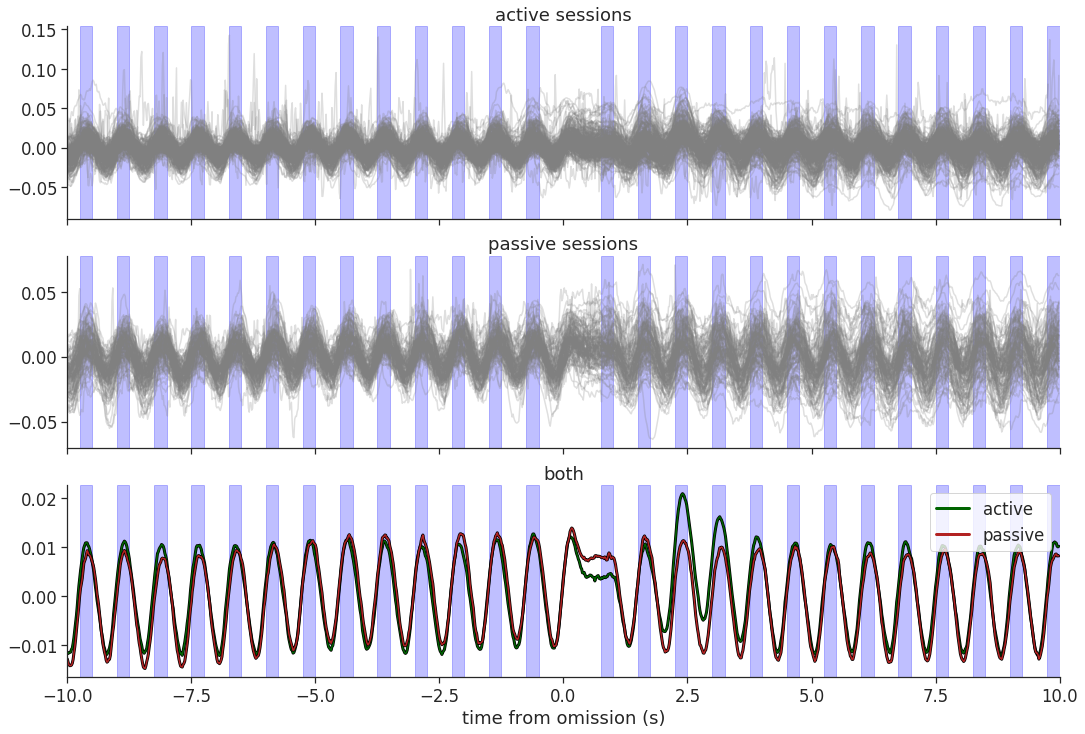

In [35]:
event = 'omission'
datastream = 'pupil'
dfs = {condition:triggered_responses['{}_{}_{}'.format(datastream,event,condition)] for condition in ['active','passive']}
fig,ax = make_plot(dfs, fraction_change=True, omit=[0])
ax[2].set_xlim(-10,10)
ax[2].set_xlabel('time from omission (s)')

Text(0.5, 58.5, 'time from omission (s)')

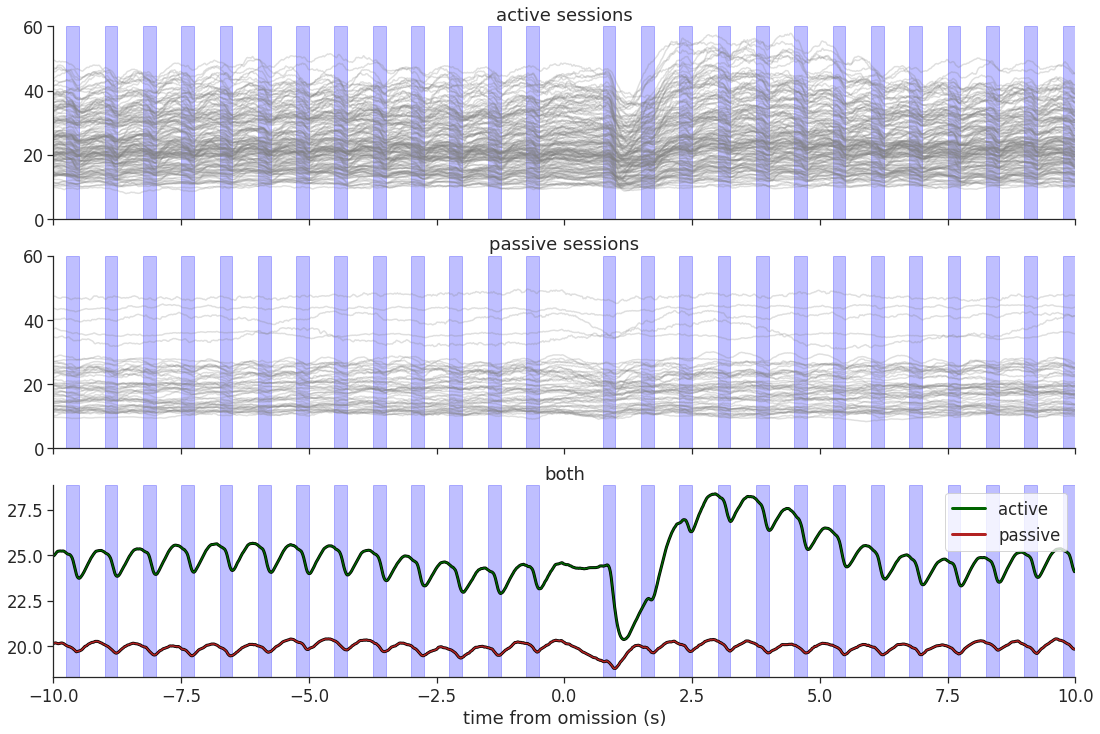

In [36]:
event = 'omission'
datastream = 'running'

running_threshold = 10 # only keep sessions where the mean running speed is above this value
dfs = {condition:triggered_responses['{}_{}_{}'.format(datastream,event,condition)] for condition in ['active','passive']}
for condition in ['active','passive']:
    means = dfs[condition].set_index('time').mean(axis=0)
    cols_to_keep = ['time'] + list(means[means>running_threshold].index.values)
    dfs[condition] = dfs[condition][cols_to_keep]
    
fig,ax = make_plot(dfs, fraction_change=False, omit=[0])
ax[2].set_xlim(-10,10)
for i in range(2):
    ax[i].set_ylim(0,60)
ax[2].set_xlabel('time from omission (s)')

Text(0.5, 58.5, 'time from change (s)')

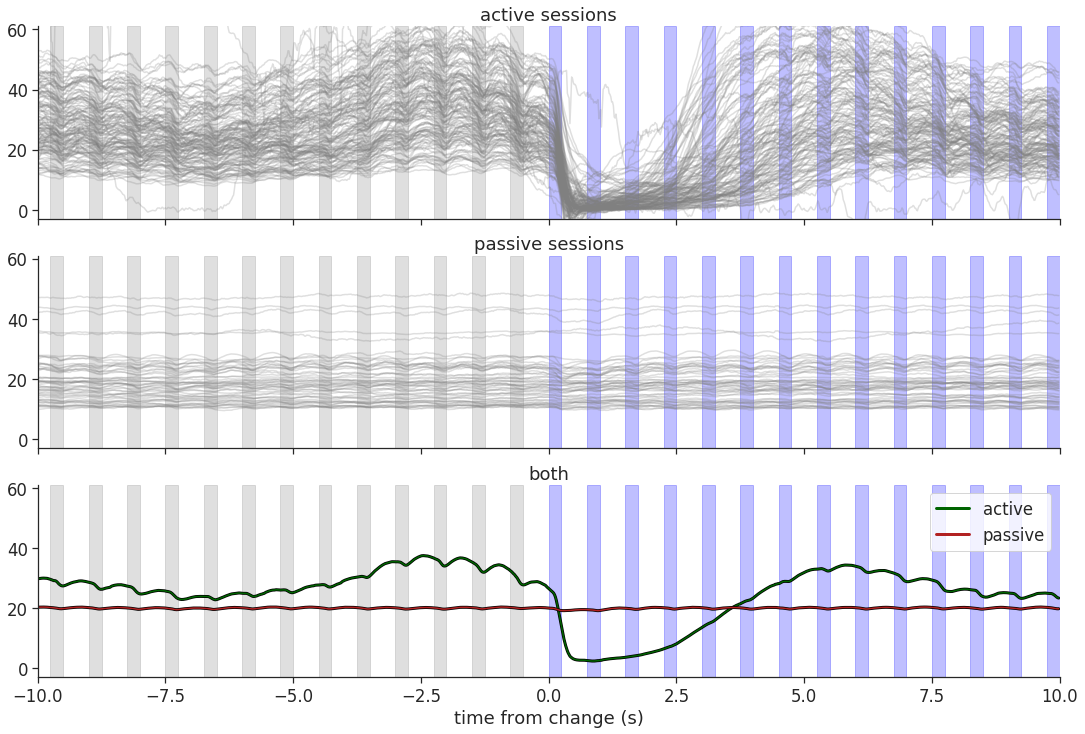

In [37]:
event = 'change'
datastream = 'running'

running_threshold = 10 # only keep sessions where the mean running speed is above this value
dfs = {condition:triggered_responses['{}_{}_{}'.format(datastream,event,condition)] for condition in ['active','passive']}
for condition in ['active','passive']:
    means = dfs[condition].set_index('time').mean(axis=0)
    cols_to_keep = ['time'] + list(means[means>running_threshold].index.values)
    dfs[condition] = dfs[condition][cols_to_keep]
    
fig,ax = make_plot(dfs, fraction_change=False, omit=None, pre_color='gray', post_color='blue')
ax[2].set_xlim(-10,10)
for i in range(3):
    ax[i].set_ylim(-3,61)
ax[2].set_xlabel('time from change (s)')

Text(0.5, 58.5, 'time from change (s)')

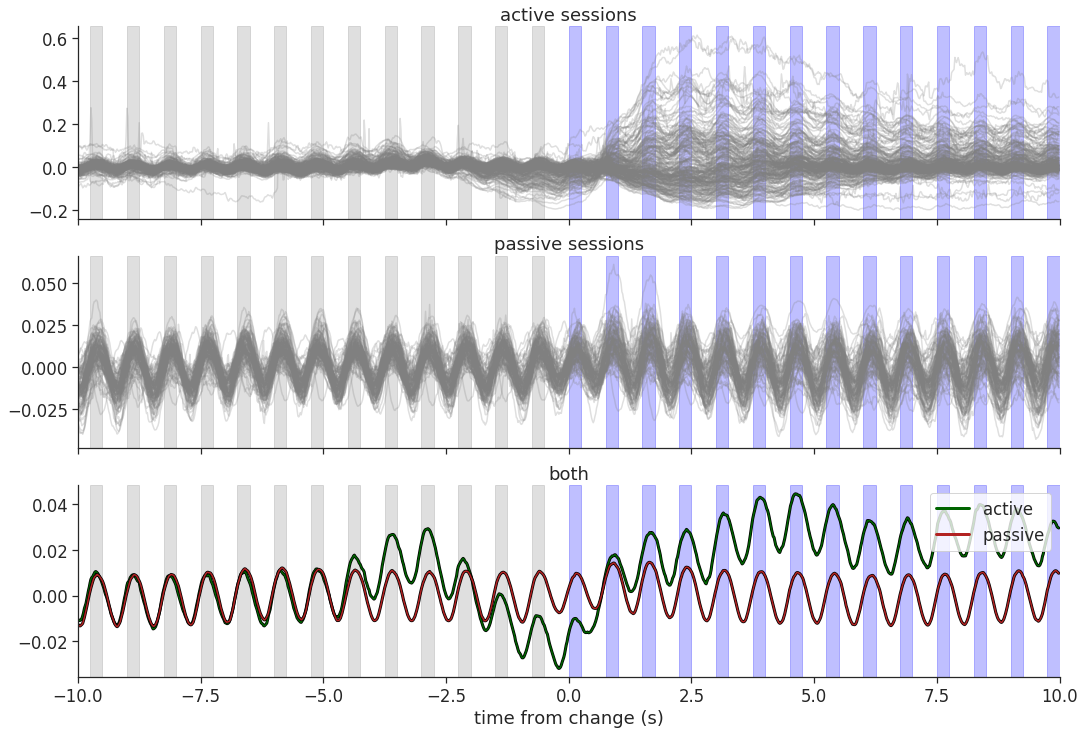

In [38]:
event = 'change'
datastream = 'pupil'

dfs = {condition:triggered_responses['{}_{}_{}'.format(datastream,event,condition)] for condition in ['active','passive']}
    
fig,ax = make_plot(dfs, fraction_change=True, omit=None, pre_color='gray', post_color='blue')
ax[2].set_xlim(-10,10)
ax[2].set_xlabel('time from change (s)')

## make a big combined matrix plot
This takes 30 seconds or so to generate

In [46]:
def make_big_matrix_plot(states, xlim=[-5,5]):
    fig = plt.figure(figsize = (13,8.5))
    vbuffer = 0.025
    hbuffer = 0.025

    row_1_2_border = 0.2125
    row_2_end = 0.425
    row_3_start = 0.575
    row_3_4_border = 0.7875


    # define axes in a dictionary with same keys as the triggered_responses dictionary
    axes = {
        'pupil_omission_{}'.format(states[0]):   vbp.placeAxesOnGrid(fig, xspan=[0,0.33-vbuffer/2],              yspan=[0,row_1_2_border-hbuffer/2]), 
        'pupil_omission_{}'.format(states[1]):   vbp.placeAxesOnGrid(fig, xspan=[0.33+vbuffer/2,0.67-vbuffer/2], yspan=[0,row_1_2_border-hbuffer/2]), 
        'pupil_omission_overlay':                vbp.placeAxesOnGrid(fig, xspan=[0.67+vbuffer/2,1],              yspan=[0,row_1_2_border-hbuffer/2]), 
        'running_omission_{}'.format(states[0]): vbp.placeAxesOnGrid(fig, xspan=[0,0.33-vbuffer/2],              yspan=[row_1_2_border+hbuffer/2,row_2_end]),
        'running_omission_{}'.format(states[1]): vbp.placeAxesOnGrid(fig, xspan=[0.33+vbuffer/2,0.67-vbuffer/2], yspan=[row_1_2_border+hbuffer/2,row_2_end]), 
        'running_omission_overlay':              vbp.placeAxesOnGrid(fig, xspan=[0.67+vbuffer/2,1],              yspan=[row_1_2_border+hbuffer/2,row_2_end]), 

        'pupil_change_{}'.format(states[0]):     vbp.placeAxesOnGrid(fig, xspan=[0,0.33-vbuffer/2],              yspan=[row_3_start,row_3_4_border-hbuffer/2]), 
        'pupil_change_{}'.format(states[1]):     vbp.placeAxesOnGrid(fig, xspan=[0.33+vbuffer/2,0.67-vbuffer/2], yspan=[row_3_start,row_3_4_border-hbuffer/2]), 
        'pupil_change_overlay':                  vbp.placeAxesOnGrid(fig, xspan=[0.67+vbuffer/2,1],              yspan=[row_3_start,row_3_4_border-hbuffer/2]), 
        'running_change_{}'.format(states[0]):   vbp.placeAxesOnGrid(fig, xspan=[0,0.33-vbuffer/2],              yspan=[row_3_4_border+hbuffer/2,1]),
        'running_change_{}'.format(states[1]):   vbp.placeAxesOnGrid(fig, xspan=[0.33+vbuffer/2,0.67-vbuffer/2], yspan=[row_3_4_border+hbuffer/2,1]), 
        'running_change_overlay':                vbp.placeAxesOnGrid(fig, xspan=[0.67+vbuffer/2,1],              yspan=[row_3_4_border+hbuffer/2,1]), 
    }

    # define active/passive colors
    colors = {
        'active':'purple',
        'passive':'limegreen',
        'familiar':'orange',
        'novel':'blue'
    }

    # iterate over events
    for event in ['omission','change']:
        # iterate over states
        for state in states:
            # pupil plots first
            # make a string for referencing into the axis and triggered response dictionaries
            condition_string = 'pupil_{}_{}'.format(event,state)
            plot_all_traces(
                vbu.convert_to_fraction(triggered_responses[condition_string], baseline_conditional = "time <= 0"), 
                axes[condition_string]
            )
            for ax in [axes[condition_string], axes['pupil_{}_overlay'.format(event)]]:
                plot_mean(
                    vbu.convert_to_fraction(triggered_responses[condition_string], baseline_conditional = "time <= 0"), 
                    ax,
                    color=colors[state]
                )

            # then running plots 
            condition_string = 'running_{}_{}'.format(event,state)
            means = triggered_responses[condition_string].set_index('time').mean(axis=0)
            cols_to_keep = ['time'] + list(means[means>running_threshold].index.values)
            df = triggered_responses[condition_string][cols_to_keep]

            plot_all_traces(
                df, 
                axes[condition_string]
            )
            for ax in [axes[condition_string], axes['running_{}_overlay'.format(event)]]:
                plot_mean(
                    df, 
                    ax,
                    color=colors[state]
                )

    # a bunch of special cases for axis labels, titles, etc.            
    for col,condition_string in enumerate(['pupil_omission_{}'.format(states[0]),'pupil_omission_{}'.format(states[1]),'pupil_omission_overlay']):
        axes[condition_string].set_ylim(-0.05,0.05)
        axes[condition_string].set_xlim(*xlim)
        axes[condition_string].set_xticklabels([])
        designate_flashes(axes[condition_string], omit=[0], pre_color='gray', post_color='gray')
        if col > 0:
            axes[condition_string].set_yticklabels([])
        else:
            axes[condition_string].set_ylabel('fraction change\nin pupil area')

    for col,condition_string in enumerate(['pupil_change_{}'.format(states[0]),'pupil_change_{}'.format(states[1]),'pupil_change_overlay']):
        axes[condition_string].set_ylim(-0.05,0.05)
        axes[condition_string].set_xlim(*xlim)
        axes[condition_string].set_xticklabels([])
        designate_flashes(axes[condition_string], omit=None, pre_color='gray', post_color='dodgerblue')
        if col > 0:
            axes[condition_string].set_yticklabels([])
        else:
            axes[condition_string].set_ylabel('fraction change\nin pupil area')


    for col,condition_string in enumerate(['running_omission_{}'.format(states[0]),'running_omission_{}'.format(states[1]),'running_omission_overlay']):
        axes[condition_string].set_ylim(-2,62)
        axes[condition_string].set_xlim(*xlim)
        axes[condition_string].set_xlabel('time from omission (s)')
        designate_flashes(axes[condition_string], omit=[0], pre_color='gray', post_color='gray')
        if col > 0:
            axes[condition_string].set_yticklabels([])
        else:
            axes[condition_string].set_ylabel('running\nspeed\n(cm\s)')


    for col,condition_string in enumerate(['running_change_{}'.format(states[0]),'running_change_{}'.format(states[1]),'running_change_overlay']):
        axes[condition_string].set_ylim(-2,62)
        axes[condition_string].set_xlim(*xlim)
        axes[condition_string].set_xlabel('time from change (s)')
        designate_flashes(axes[condition_string], omit=None, pre_color='gray', post_color='dodgerblue')
        if col > 0:
            axes[condition_string].set_yticklabels([])
        else:
            axes[condition_string].set_ylabel('running\nspeed\n(cm\s)')

    axes['pupil_omission_{}'.format(states[0])].set_title('{}'.format(states[0]))
    axes['pupil_omission_{}'.format(states[1])].set_title('{}'.format(states[1]))
    axes['pupil_omission_overlay'].set_title('{}/{} overlay'.format(states[0], states[1]))

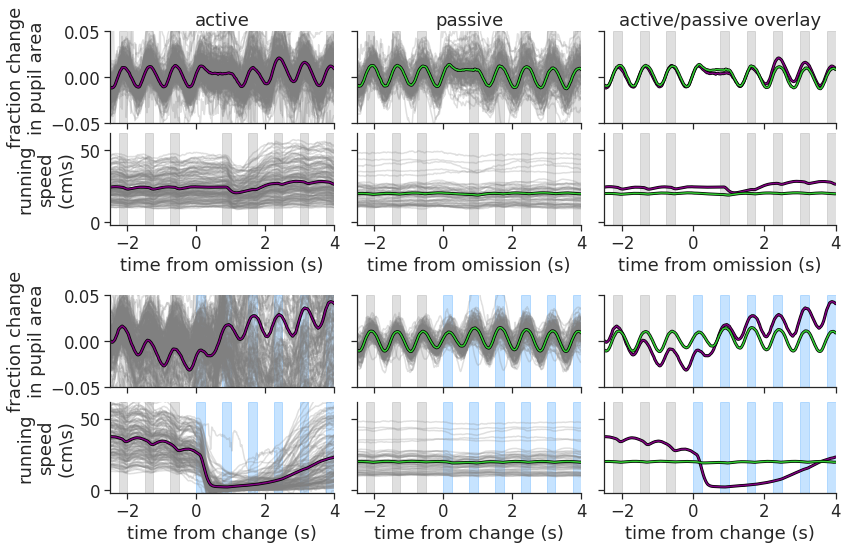

In [47]:
make_big_matrix_plot(states=['active','passive'], xlim=[-2.5,4])

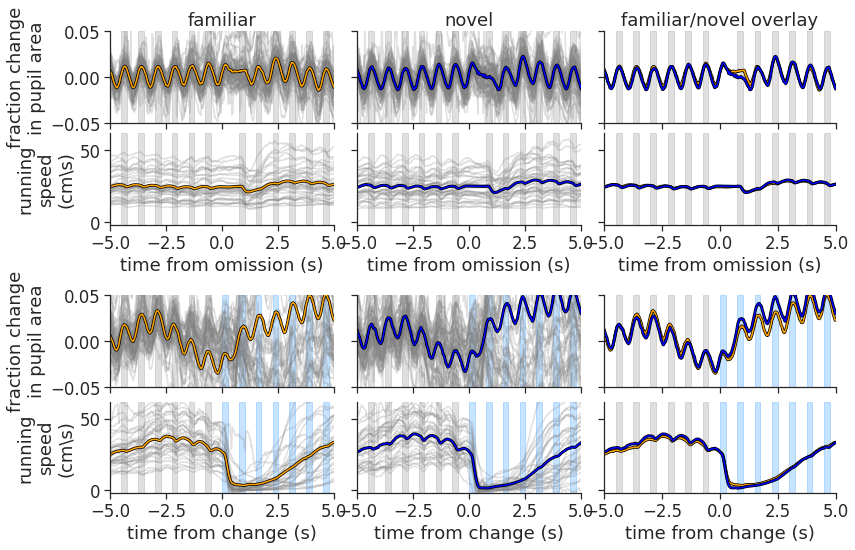

In [45]:
make_big_matrix_plot(states=['familiar','novel'])